## Causal attention

### What have we covered so far

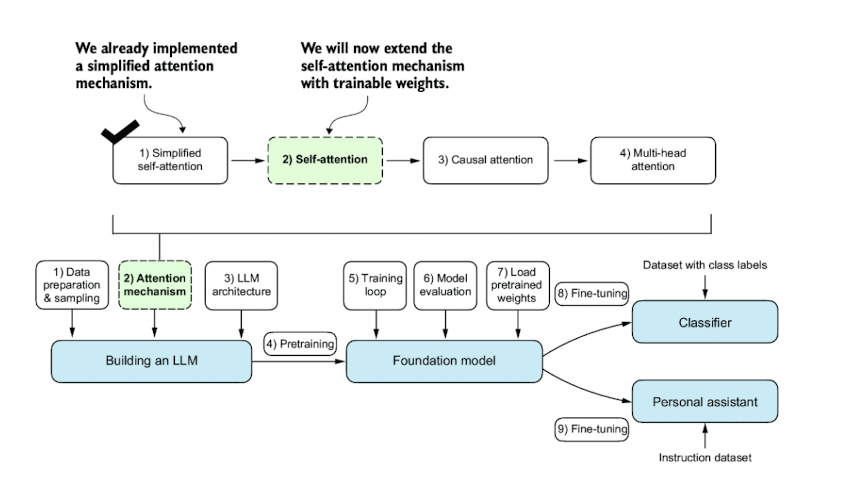

#### Review of Self Attention Mechanism

<div class="alert alert-block alert-success">
We want to compute the context Vector for every given input token. So this objective is the same as the objective was in the self attention remember that we did previously. We want to take each token embedding add attention (how this token related to all the other tokens in the sentence) to it and generate a context vector for that token. The context Vector can be thought of as an enriched input embedding Vector.

IN self attention with trianable weights, we will introduce the concept of trainable weight matrices that are updated during model training. These trainable weight matrices are crucial so that the model (specifically, the attention module inside the model) can learn to produce “good” context vectors.
#### So what did we do 
We implemented the self-attention mechanism step by step by introducing the three trainable weight matrices Wq, Wk, and Wv. three The first is called the weight Matrix for query, the second is called weight Matrix for key and the third is called the weight Matrix for Value These three matrices are used to project the embedded input tokens, x(i), into query, key, and value vectors, respectively.
The first step here is to convert the input embeddings into key query and value vectors.


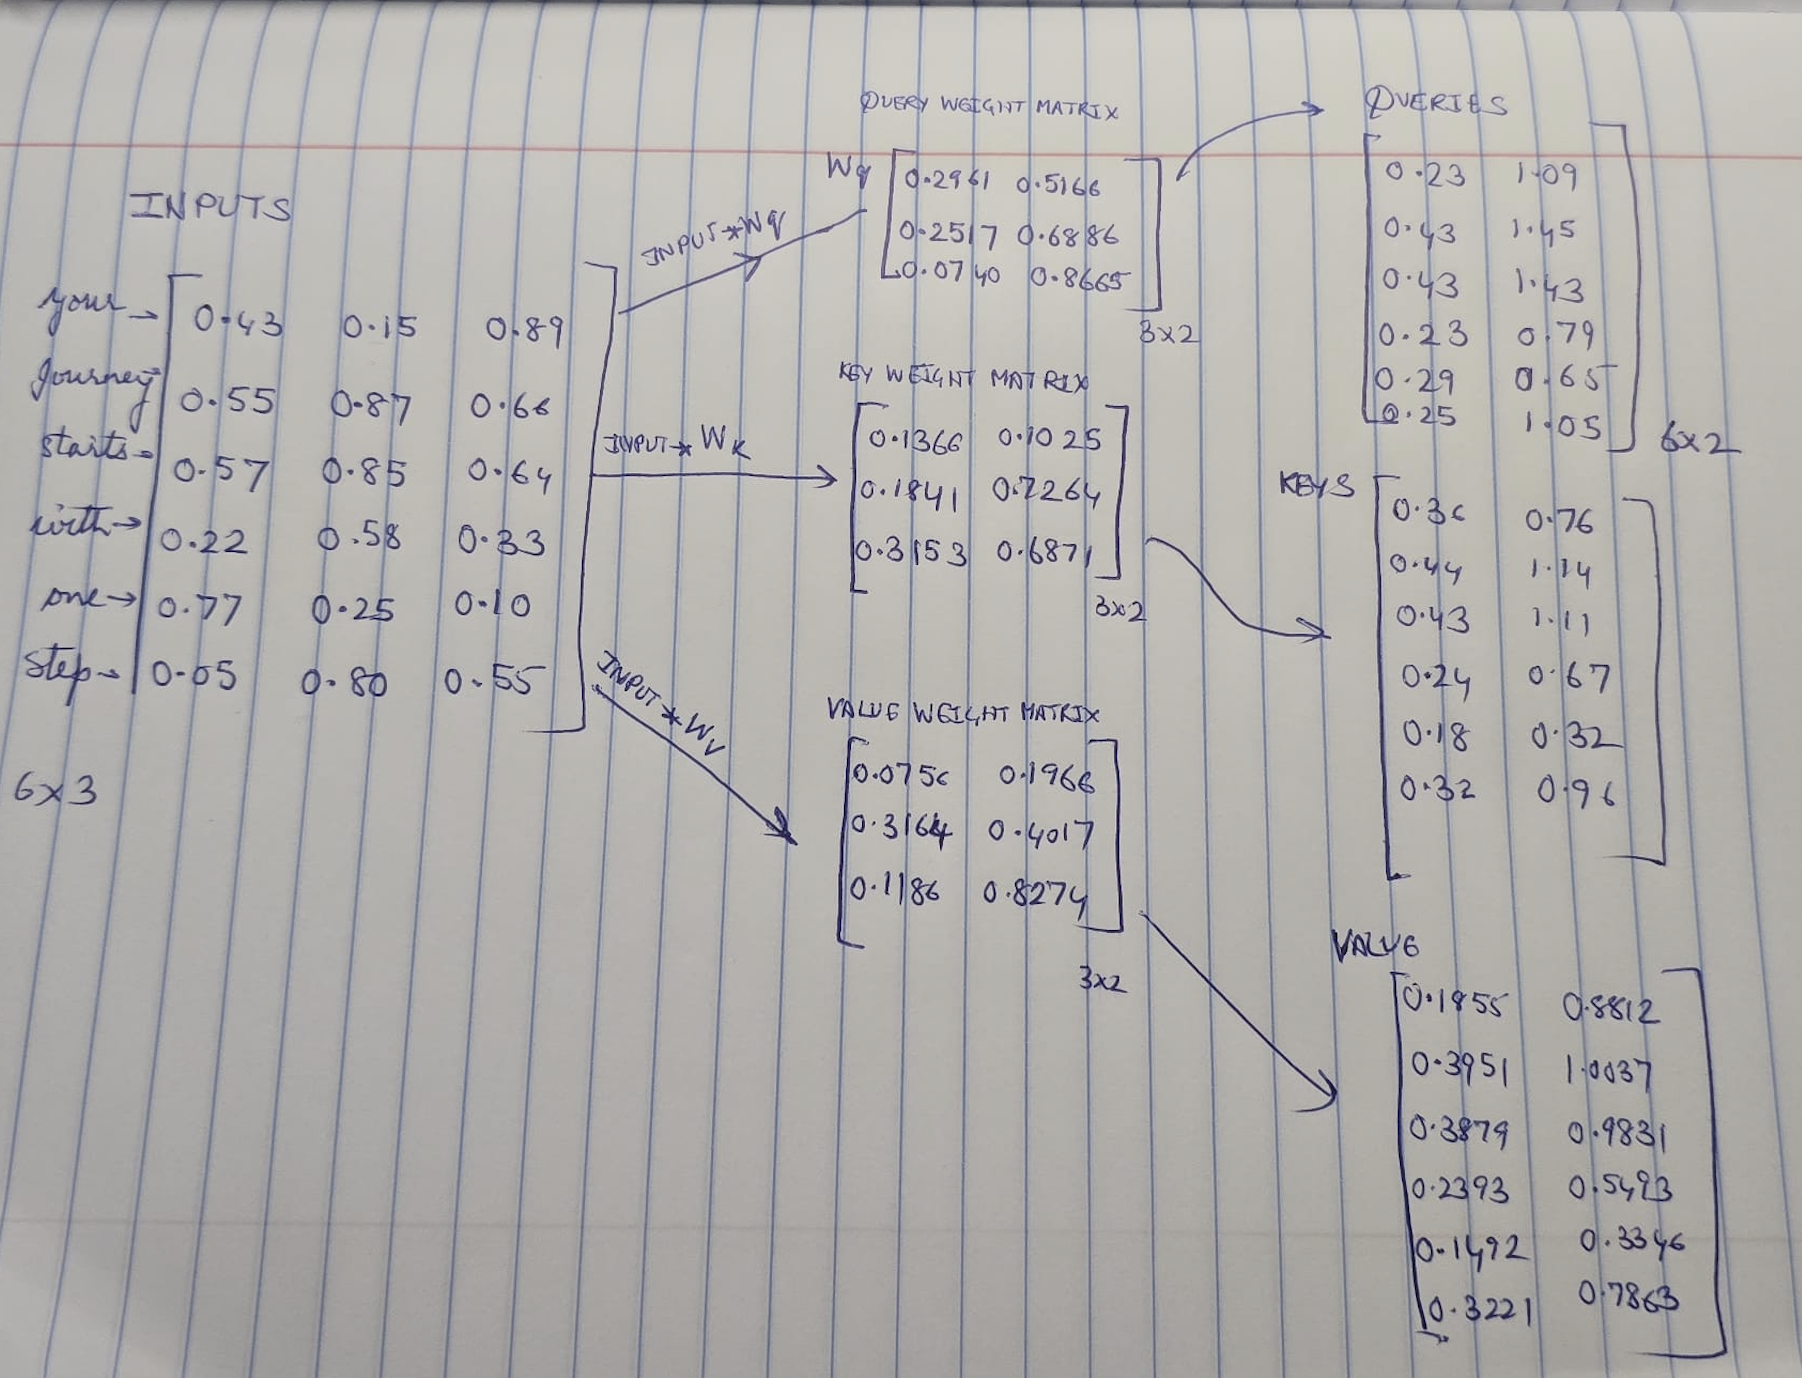

We have initialized the query weight matrix, key weight matrix and the value weight matrix with some random values but these are the ones which are actually trained. Initially we do not know these parameters so we initialize them randomly and then train them so as to get context vectors later. What these matrices do is actually they project the inputs into a different dimension space. The simplest way to think of the query Matrix and all the other weight matrices is the transformation from let's say a 3 dimensional space into in this case a 2 dimensional space.

So the way to interpret the query key and the value is that every row of the query key and value essentially represents one token and a representation for that token. So henceforth after we get the queries key and values we are no longer going to look at the input embeddings.The input embeddings have been transformed into three matrices the query Matrix, the key Matrix and the value Matrix

Also this transformation is not fixed. The key to these Transformations are these three weight matrices WQ, WK and WV. The parameters of these weight matrices are to be optimized later that's why these are called as the trainable weight matrices.

### Computing Attention Score
The attention score computation is a dot-product computation similar to what we used in the simplified self-attention mechanism. The new aspect here is that we are not directly computing the dot-product between the input elements but using the query and key obtained by transforming the inputs via the respective weight matrices.

### Finally Calculating the context
We now compute the context vector as a weighted sum over the value vectors.Here, the attention weights serve as a weighting factor that weighs the respective importance of each value vector. We can use matrix multiplication to obtain the output in one step:

</div>

<div class="alert alert-block alert-info">
    
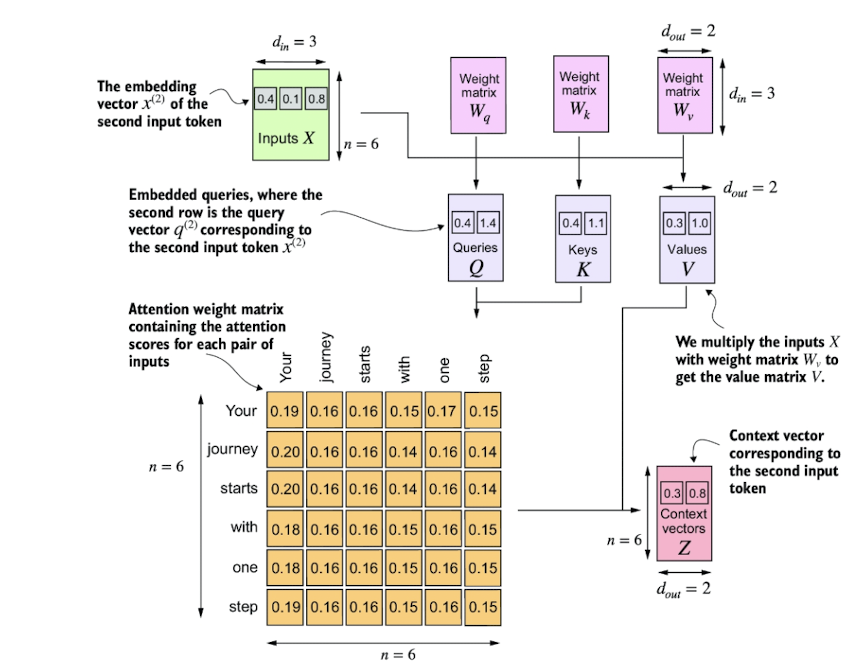

In self-attention, we transform the input vectors in the input matrix X with the three weight matrices, Wq, Wk, and Wv. <br>
The new compute the attention weight matrix based on the resulting queries (Q) and keys (K). <br>
Using the attention weights and values (V), we then compute the context vectors (Z). <br>
For visual clarity, we focus on a single input text with n tokens, not a batch of multiple inputs. 
Consequently, the three-dimensional input tensor is simplified to a two-dimensional matrix in this context. 
This approach allows for a more straightforward visualization and understanding of the processes involved. 
For consistency with later figures, the values in the attention matrix do not depict the real attention weights. (The numbers in this figure are truncated to two digits after the decimal point to reduce visual clutter. The values in each row should add up to 1.0 or 100%.)


</div>

### Causal Attention Aspect

<div class="alert alert-block alert-success">
The causal aspect involves modifying the attention mechanism to prevent the model from accessing future information in the sequence, which is crucial for tasks like language modeling, where each word prediction should only depend on previous words.
For many LLM tasks, you will want the self-attention mechanism to consider only the tokens that appear prior to the current position when predicting the next token in a sequence. Causal attention, also known as masked attention, is a specialized form of self-attention. It restricts a model to only consider previous and current inputs in a sequence when processing any given token when computing attention scores. This is in contrast to the standard self-attention mechanism, which allows access to the entire input sequence at once.

</div>

<div class="alert alert-block alert-info">
The causal aspect involves modifying the attention mechanism to prevent the model from accessing future information in the sequence, which is crucial for tasks like language modeling, where each word prediction should only depend on previous words.
For many LLM tasks, you will want the self-attention mechanism to consider only the tokens that appear prior to the current position when predicting the next token in a sequence. Causal attention, also known as masked attention, is a specialized form of self-attention. It restricts a model to only consider previous and current inputs in a sequence when processing any given token when computing attention scores. This is in contrast to the standard self-attention mechanism, which allows access to the entire input sequence at once.
</div>

## HIDING FUTURE WORDS WITH CAUSAL ATTENTION

<div class="alert alert-block alert-success">

Let's work with the attention scores and weights from the previous section to code the causal attention mechanism.
    
</div>

<div class="alert alert-block alert-success">

We will modify the standard self-attention mechanism to create a causal attention mechanism, which is essential for developing an LLM in the subsequent chapters. To achieve this in GPT-like LLMs, for each token processed, we mask out the future tokens, which come after the current token in the input text, as illustrated in figure below. We mask out the attention weights above the diagonal, and we normalize the nonmasked attention weights such that the attention weights sum to 1 in each row. Later, we will implement this masking and normalization procedure in code.

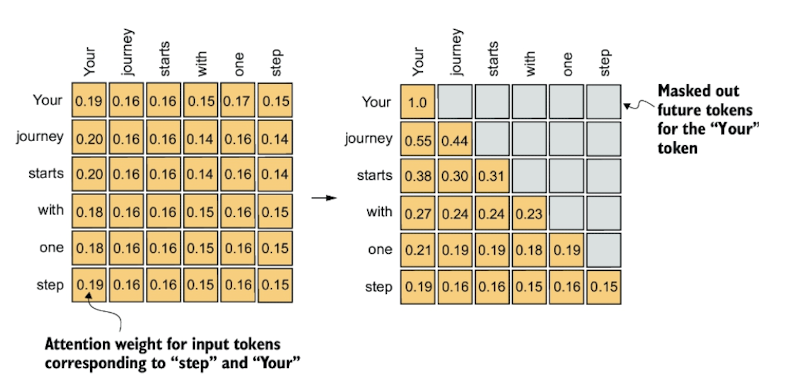  

In causal attention, we mask out the attention weights above the diagonal such that for a given input, the LLM can’t access future tokens when computing the context vectors using the attention weights. For example, for the word “journey” in the second row, we only keep the attention weights for the words before (“Your”) and in the current position (“journey”).

The data above diagonal will be masked and it's called as the causal attention mask because we are masking out all of those attention weights that lie above the diagonal.
</div>


<div class="alert alert-block alert-info">

Reuse the query and key weight matrices of the SelfAttention_v2 object from the previous section for
convenience
    
</div>

In [6]:
import torch
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

In [8]:
import torch.nn as nn

class SelfAttention_v2(nn.Module):

    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        
        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

        context_vec = attn_weights @ values
        return context_vec

In [9]:
x_2 = inputs[1] #A
d_in = inputs.shape[1] #B
d_out = 2 #C

In [11]:
torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


In [12]:
queries = sa_v2.W_query(inputs) #A
keys = sa_v2.W_key(inputs)
attn_scores = queries @ keys.T
attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=1)
print(attn_weights)

tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


In [14]:
context_length = attn_scores.shape[0]

<div class="alert alert-block alert-success">
Our next step is to implement the causal attention mask in code. To implement the steps to apply a causal attention mask to obtain the masked attention weights, as summarized in figure below, let’s work with the attention scores and weights from the previous section to code the causal attention mechanism.

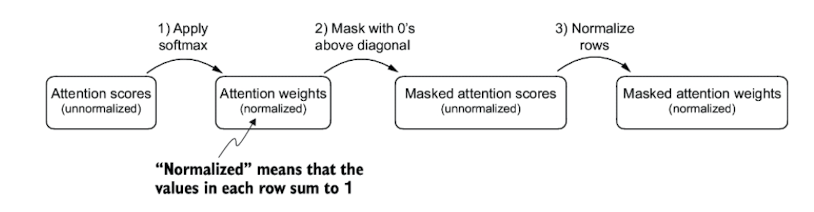

One way to obtain the masked attention weight matrix in causal attention is to apply the softmax function to the attention scores, zeroing out the elements above the diagonal and normalizing the resulting matrix.

We can now use PyTorch's tril function to create a mask
where the values above the diagonal are zero:
If you use Trill what it will result is it will result in a lower triangular Matrix which means that all the elements above the diagonal will be set to zero. So to construct a mask which all values above the diagnal is 0 we will use pytorch's tril matrix.

</div>

In [15]:
torch.ones(context_length, context_length)

tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]])

In [16]:
context_length = attn_scores.shape[0]
mask_simple = torch.tril(torch.ones(context_length, context_length))
print(mask_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


<div class="alert alert-block alert-success">
If you multiply this attention weight Matrix with this mask simple what you should get is that all the elements above the diagonal will be set to zero and this is what is exactly desired,
So, we can multiply this mask with the attention weights to zero out the values above the
diagonal:

</div>

In [17]:
masked_simple = attn_weights*mask_simple
print(masked_simple)

tensor([[0.1921, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2041, 0.1659, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2036, 0.1659, 0.1662, 0.0000, 0.0000, 0.0000],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.0000, 0.0000],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<MulBackward0>)


<div class="alert alert-block alert-info">

As we can see, the elements above the diagonal are successfully zeroed out
    
</div>

<div class="alert alert-block alert-success">

The third step is to renormalize the attention weights to sum up to 1 again in
each row. 

We can achieve this by dividing each element in each row by the <b>sum</b> in each
row:

</div>

In [18]:
row_sums = masked_simple.sum(dim=1, keepdim=True)
masked_simple_norm = masked_simple / row_sums
print(masked_simple_norm)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<DivBackward0>)


<div class="alert alert-block alert-info">

The result is an attention weight matrix where the attention weights above the diagonal are
zeroed out and where the rows sum to 1.

</div>

<div class="alert alert-block alert-info">
<b> What is the issue with this approach </b> </br>
If you look at the causal attention the main purpose of causal attention essentially is to not have any influence of the future tokens right but if you carefully see what we have done here we have essentially applied soft Max to the attention scores which we had obtained earlier.
So even if you zero out all the future tokens it's not essentially cancelling the influence of the future. The non masked tokens have already been influenced by the future tokens. This is also called information leakage and needs to be fixed.
</div>

<div class="alert alert-block alert-info">
<b> So how do we solve this </b>

When we apply a mask and then renormalize the attention weights, it might initially appear that information from future tokens (which we intend to mask) could still influence the current token because their values are part of the softmax calculation. However, the key insight is that when we renormalize the attention weights after masking, what we’re essentially doing is recalculating the softmax over a smaller subset (since masked positions don’t contribute to the softmax value). The mathematical elegance of softmax is that despite initially including all positions in the denominator, after masking and renormalizing, the effect of the masked positions is nullified—they don’t contribute to the softmax score in any meaningful way. In simpler terms, after masking and renormalization, the distribution of attention weights is as if it was calculated only among the unmasked positions to begin with. This ensures there’s no information leakage from future (or otherwise masked) tokens as we intended.

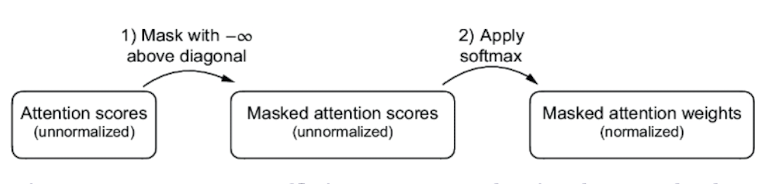

A much more efficient way to obtain the masked attention weight matrix in causal attention is to mask the attention scores with negative infinity values before applying the softmax function.


</div>

<div class="alert alert-block alert-success">

While we could be technically done with implementing causal attention at this point, we can
take advantage of a mathematical property of the softmax function. 

We can implement the computation of the masked attention weights more efficiently in fewer steps.

</div>

<div class="alert alert-block alert-success">

The softmax function converts its inputs into a probability distribution. 

When negative
infinity values (-∞) are present in a row, the softmax function treats them as zero
probability. 

(Mathematically, this is because e
-∞ approaches 0.)


We can implement this more efficient masking "trick" by creating a mask with 1's above
the diagonal and then replacing these 1's with negative infinity (-inf) values:

</div>

In [19]:
print(attn_scores)

tensor([[ 0.2899,  0.0716,  0.0760, -0.0138,  0.1344, -0.0511],
        [ 0.4656,  0.1723,  0.1751,  0.0259,  0.1771,  0.0085],
        [ 0.4594,  0.1703,  0.1731,  0.0259,  0.1745,  0.0090],
        [ 0.2642,  0.1024,  0.1036,  0.0186,  0.0973,  0.0122],
        [ 0.2183,  0.0874,  0.0882,  0.0177,  0.0786,  0.0144],
        [ 0.3408,  0.1270,  0.1290,  0.0198,  0.1290,  0.0078]],
       grad_fn=<MmBackward0>)


In [20]:
torch.triu(torch.ones(context_length, context_length))

tensor([[1., 1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1.]])

In [21]:
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
print(mask)

tensor([[0., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0.]])


In [22]:
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)

tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)


<div class="alert alert-block alert-success">

Now, all we need to do is apply the softmax function to these masked results, and we are
done.

</div>

In [23]:
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


<div class="alert alert-block alert-info">

As we can see based on the output, the values in each row sum to 1, and no further
normalization is necessary.

</div>

<div class="alert alert-block alert-warning">

Masking in Transformers sets scores for future tokens to a large negative value, making their influence in the softmax calculation effectively zero. 

The softmax function then recalculates attention weights only among the unmasked tokens. 

This process ensures no information leakage from masked tokens, focusing the model solely on the intended data.

</div>

<div class="alert alert-block alert-warning">

We could now use the modified attention weights to compute the context vectors via
context_vec = attn_weights @ values.

However, in the next section,
we first cover another minor tweak to the causal attention mechanism that is useful for
reducing overfitting when training LLMs.

</div>

## Dropout

<div class="alert alert-block alert-success">

In deep learning, "dropout" is a powerful regularization technique used to prevent overfitting in neural networks. </br>
**What is Overfitting?**

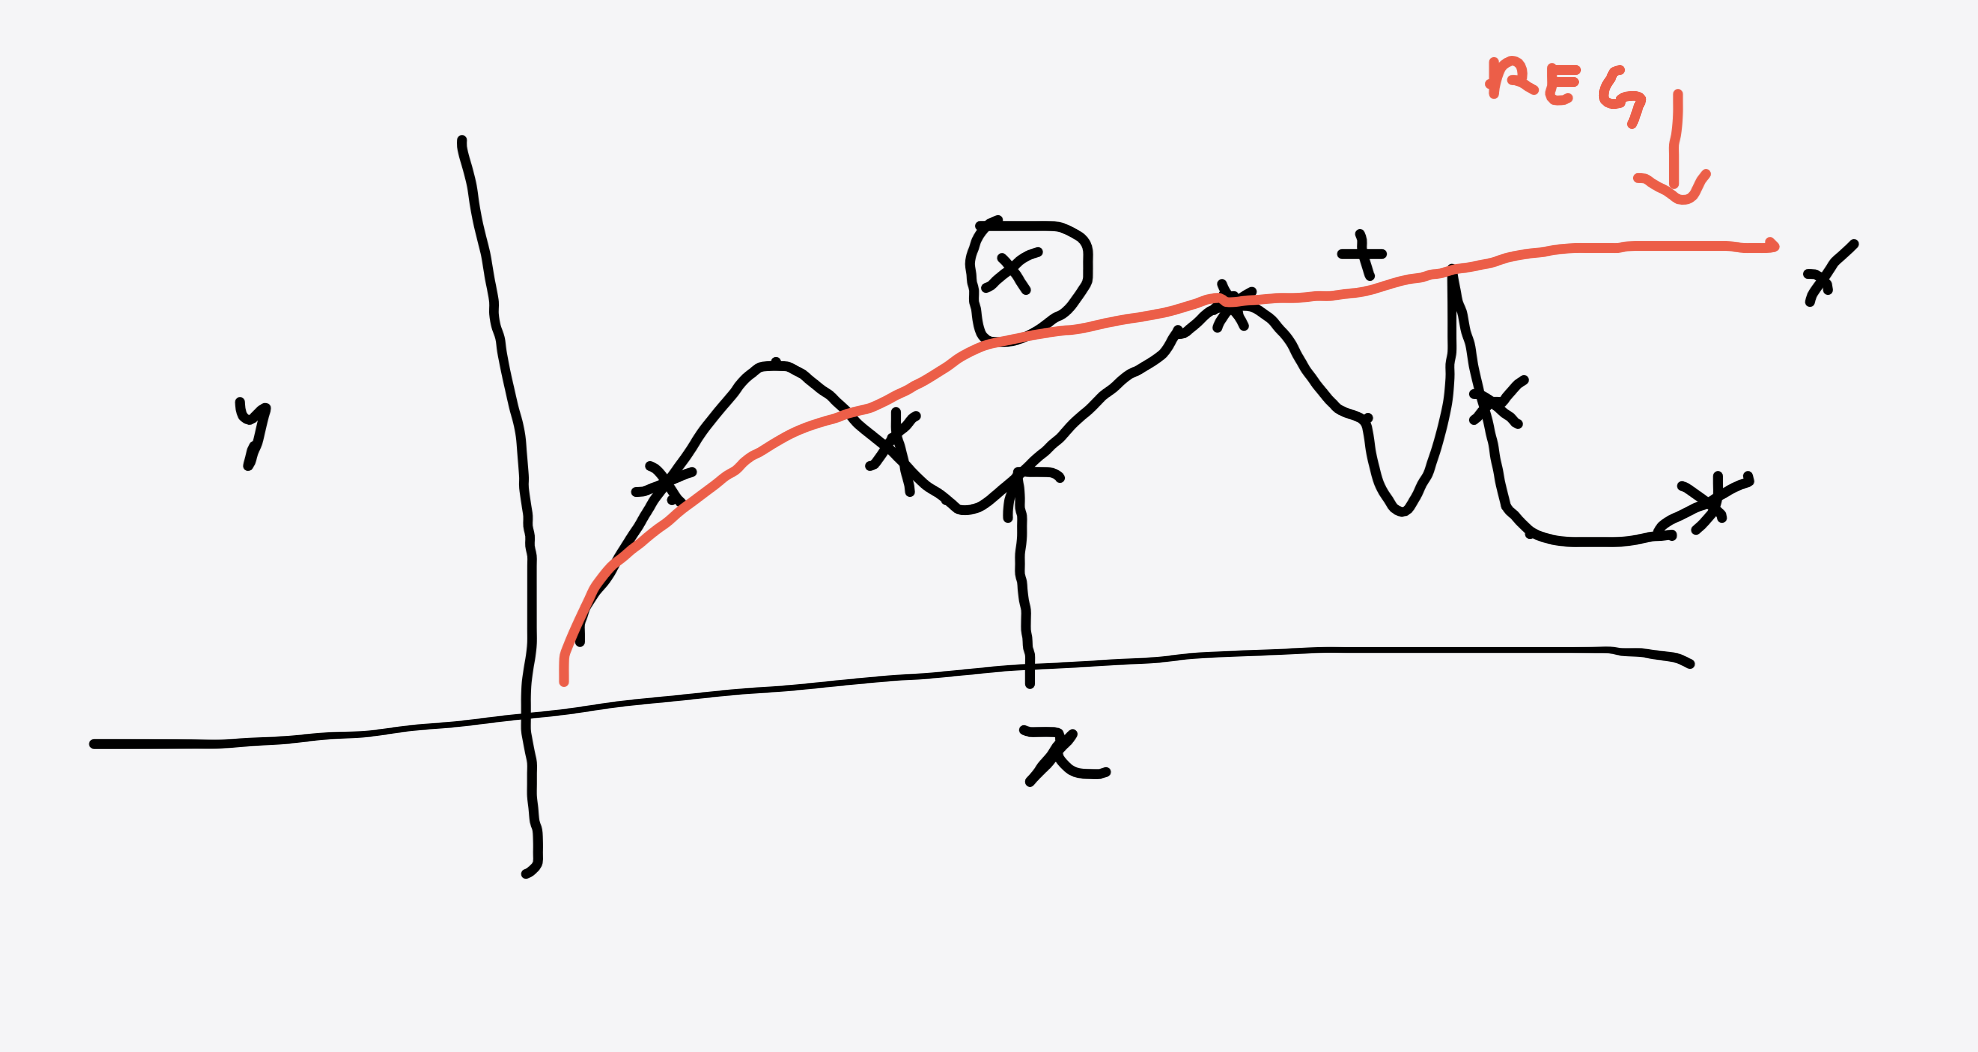

* Before diving into dropout, it's essential to understand overfitting. Overfitting occurs when a neural network learns the training data too well, including its noise and idiosyncrasies. This leads to excellent performance on the training data but poor performance on unseen data (test data).

**What is Dropout?**

* Dropout is a technique that randomly "drops out" (i.e., deactivates) a fraction of neurons in a neural network during training. This means that, during each training iteration, some neurons and their connections are temporarily removed from the network.
* This random dropping of neurons forces the network to learn more robust and generalizable features, as it cannot rely on any single neuron or set of neurons.

**How Dropout Works:**

* **During Training:**
    * For each training batch, a random subset of neurons is selected and deactivated.
    * This effectively creates a different, smaller neural network for each training iteration.
    * The network is then trained on this reduced network.
    * This process is repeated for each batch, with a different set of neurons being dropped out each time.
* **During Testing (Inference):**
    * During testing, all neurons are active.
    * However, to compensate for the fact that more neurons are active during testing than during training, the outputs of the neurons are typically scaled down by the dropout rate. This ensures that the network's output remains consistent.

**Benefits of Dropout:**

* **Reduces Overfitting:** By preventing the network from becoming too reliant on specific neurons, dropout helps to reduce overfitting and improve generalization.
* **Ensemble Effect:** Dropout can be seen as training an ensemble of many smaller neural networks, which are then averaged during testing. This ensemble effect can lead to improved performance.
* **Forces Robust Feature Learning:** Neurons are forced to learn features that are useful in conjunction with many different combinations of other neurons.

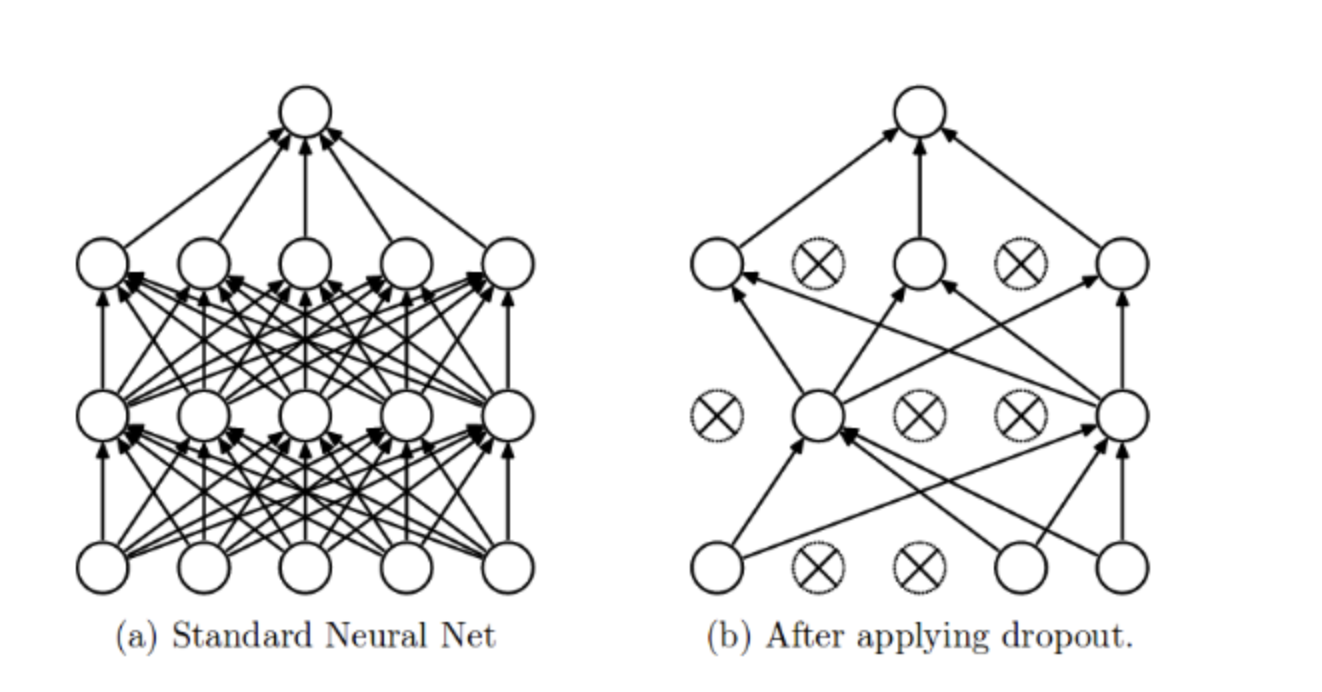

**Key Points:**

* The "dropout rate" is a hyperparameter that determines the fraction of neurons to drop out. Common values range from 0.2 to 0.5.
* Dropout is typically applied to fully connected layers but can also be used in convolutional and recurrent layers.
* It is a very common tool, used in many state of the art deep learning models.

In essence, dropout adds noise to the training process, which helps to create a more robust and resilient neural network.
</div>

<div class="alert alert-block alert-info">

<h2> How is dropout carried out in Transformer Architecture </h2> </br>
In models like GPT, dropout in the attention mechanism is typically applied at two specific times: after calculating the attention weights or after applying the attention weights to the value vectors. Here we will apply the dropout mask after computing the attention weights, as illustrated in figure below , because it’s the more common variant in practice.

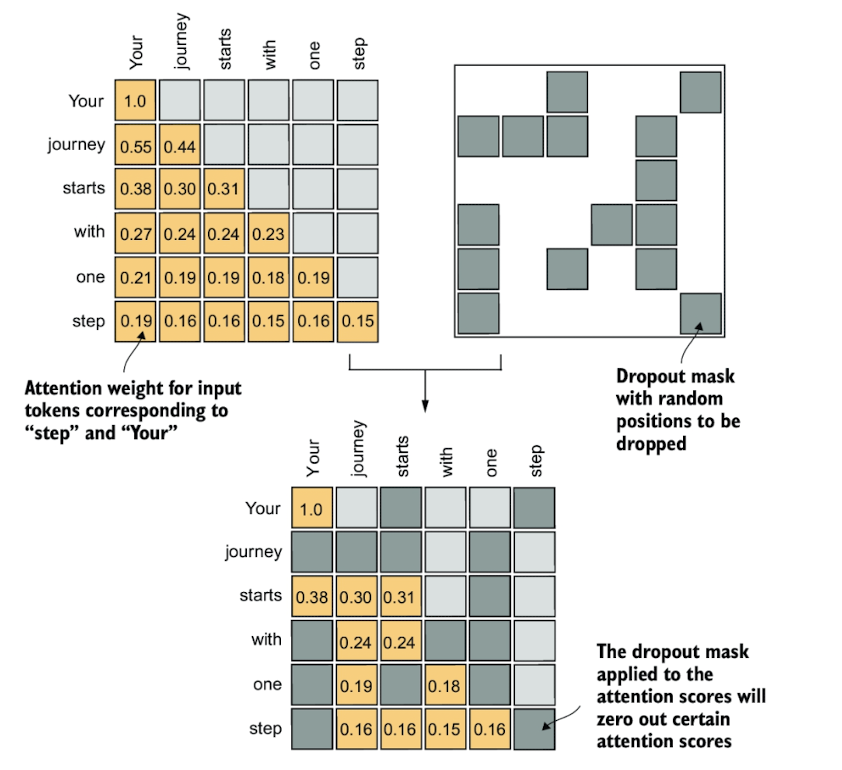

Using the causal attention mask (upper left), we apply an additional dropout mask (upper right) to zero out additional attention weights to reduce overfitting during training.
</div>

### MASKING ADDITIONAL ATTENTION WEIGHTS WITH DROPOUT

<div class="alert alert-block alert-success">

In the following code example, we use a dropout rate of 50%, which means masking out
half of the attention weights.

When we train the GPT model in later chapters, we will use a
lower dropout rate, such as 0.1 or 0.2.
</div>

<div class="alert alert-block alert-success">

In the following code, we apply PyTorch's dropout implementation first to a 6×6 tensor
consisting of ones for illustration purposes:
</div>

In [24]:
example = torch.ones(6, 6) #B
print(example)

tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]])


In [25]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5) #A
example = torch.ones(6, 6) #B
print(dropout(example))

tensor([[2., 2., 0., 2., 2., 0.],
        [0., 0., 0., 2., 0., 2.],
        [2., 2., 2., 2., 0., 2.],
        [0., 2., 2., 0., 0., 2.],
        [0., 2., 0., 2., 0., 2.],
        [0., 2., 2., 2., 2., 0.]])


<div class="alert alert-block alert-info">

When applying dropout to an attention weight matrix with a rate of 50%, half of the
elements in the matrix are randomly set to zero. 

To compensate for the reduction in active
elements, the values of the remaining elements in the matrix are scaled up by a factor of
1/0.5 =2. 

This scaling is crucial to maintain the overall balance of the attention weights,
ensuring that the average influence of the attention mechanism remains consistent during
both the training and inference phases.

Training vs. Inference:

<b>During training, dropout randomly deactivates a fraction of neurons. This means that the layer's output is effectively reduced.
During inference (when the model is used for predictions), all neurons are active. If we didn't do any scaling, the layer's output would be significantly larger than what it was during training. This inconsistency would lead to inaccurate predictions. </b> </br>
Maintaining Expected Output:
The scaling is done to ensure that the expected output of a layer is the same during both training and inference. This helps to maintain consistency and stability in the model's behavior.   

</div>

<div class="alert alert-block alert-success">

Now, let's apply dropout to the attention weight matrix itself:

</div>

In [26]:
torch.manual_seed(123)
print(dropout(attn_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7599, 0.6194, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4921, 0.4925, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3966, 0.0000, 0.3775, 0.0000, 0.0000],
        [0.0000, 0.3327, 0.3331, 0.3084, 0.3331, 0.0000]],
       grad_fn=<MulBackward0>)


<div class="alert alert-block alert-info">

As we can see above, the resulting attention weight matrix now has additional elements zeroed out and the
remaining ones rescaled.
    
</div>

<h3> New Causal Attention Flow </h3>

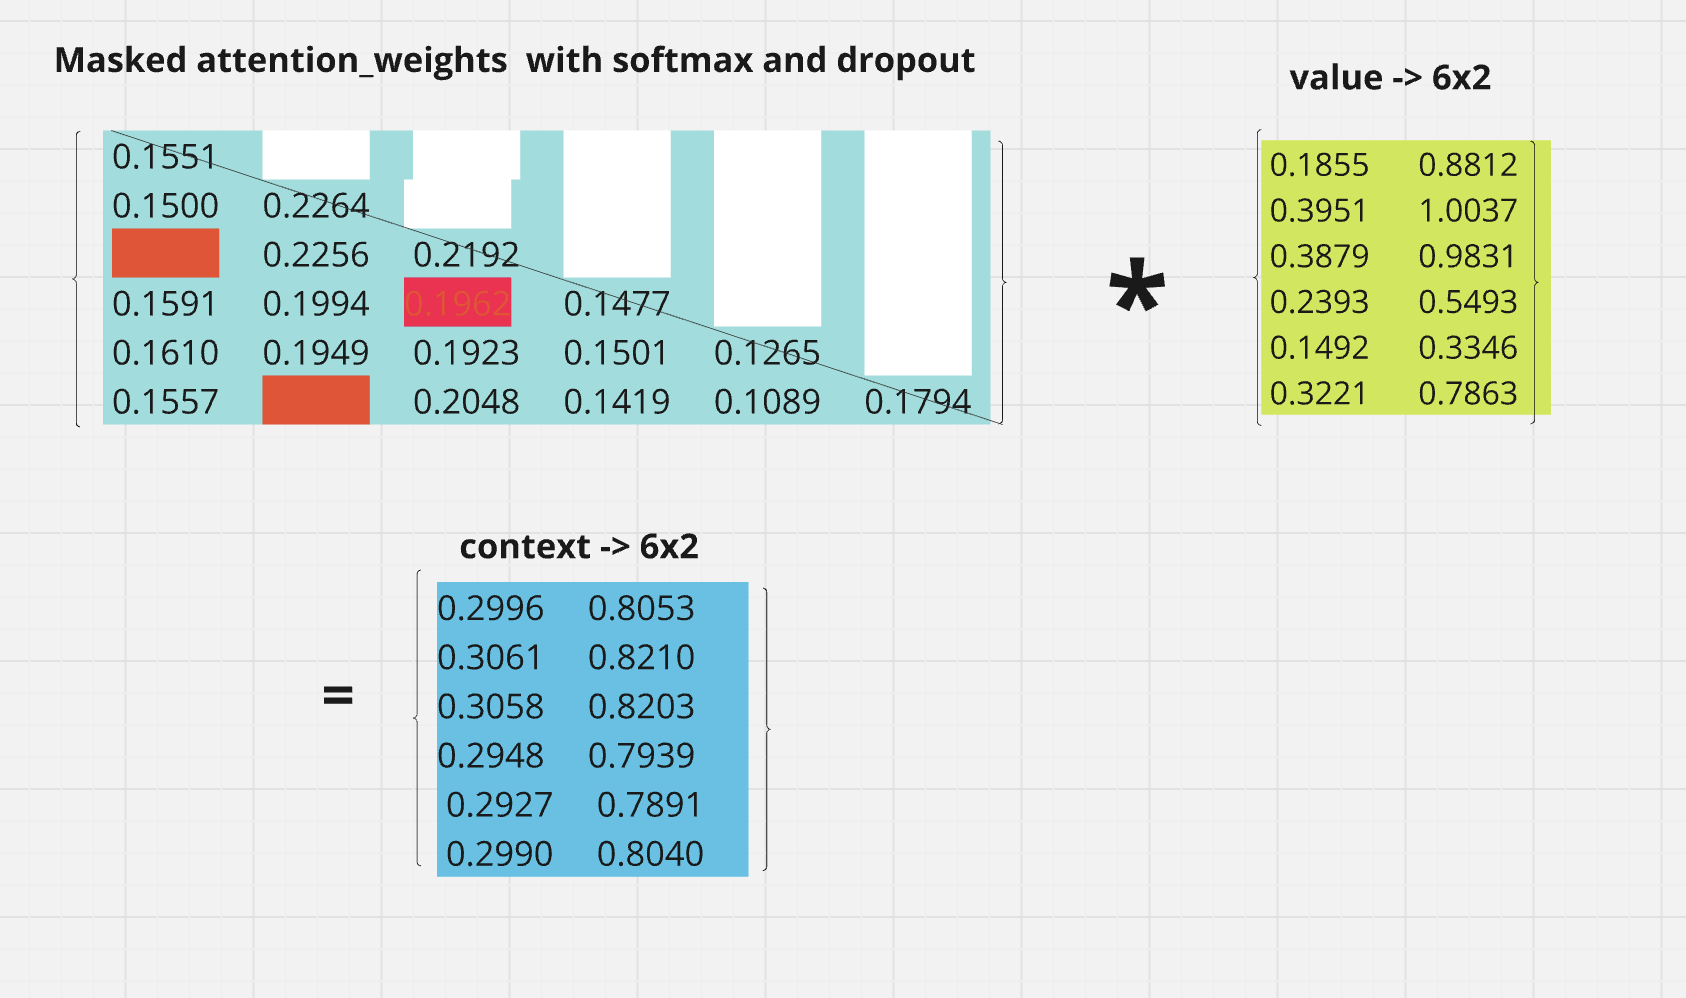

<div class="alert alert-block alert-warning">

Having gained an understanding of causal attention and dropout masking, we will
develop a concise Python class in the following section. 

This class is designed to facilitate
the efficient application of these two techniques.

</div>

### IMPLEMENTING A COMPACT CAUSAL ATTENTION CLASS

<div class="alert alert-block alert-success">

In this section, we will now incorporate the causal attention and dropout modifications into
the SelfAttention Python class we developed above. 

This class will then serve as a
template for developing multi-head attention in the upcoming section.

</div>

<div class="alert alert-block alert-success">

Before we begin, one more thing is to ensure that the code can handle batches
consisting of more than one input. 

This will ensure that the CausalAttention class supports the batch
outputs produced by the data loader we implemented earlier.

</div>

<div class="alert alert-block alert-success">

<b> For simplicity, to simulate such batch inputs, we duplicate the input text example: </b>

</div>

<div class="alert alert-block alert-info">

 2 inputs with 6 tokens each, and each token has embedding dimension 3
    
</div>

In [27]:
batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape) 

torch.Size([2, 6, 3])


<div class="alert alert-block alert-info">

This results in a 3D tensor consisting of 2 input texts with 6 tokens each, where each token
is a 3-dimensional embedding vector.
    
</div>

<div class="alert alert-block alert-success">

The following CausalAttention class is similar to the SelfAttention class we
implemented earlier, except that we now added the dropout and causal mask components
as highlighted in the following code.
    
</div>

<div class="alert alert-block alert-info">

Step 1: Compared to the previous SelfAttention_v1 class, we added a dropout layer.
    
Step 2: The register_buffer call is also a new addition (more information is provided in the following text).

Step 3:  We transpose dimensions 1 and 2, keeping the batch dimension at the first position (0).

Step 4: In PyTorch, operations with a trailing underscore are performed in-place, avoiding unnecessary memory
copies
    
</div>

In [28]:
class CausalAttention(nn.Module):

    def __init__(self, d_in, d_out, context_length,
                 dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout) # New
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1)) # New

    def forward(self, x):
        b, num_tokens, d_in = x.shape # New batch dimension b
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.transpose(1, 2) # Changed transpose
        attn_scores.masked_fill_(  # New, _ ops are in-place
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)  # `:num_tokens` to account for cases where the number of tokens in the batch is smaller than the supported context_size
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        attn_weights = self.dropout(attn_weights) # New

        context_vec = attn_weights @ values
        return context_vec

<div class="alert alert-block alert-info">
<h3> Masked Attention with Batches</h3>

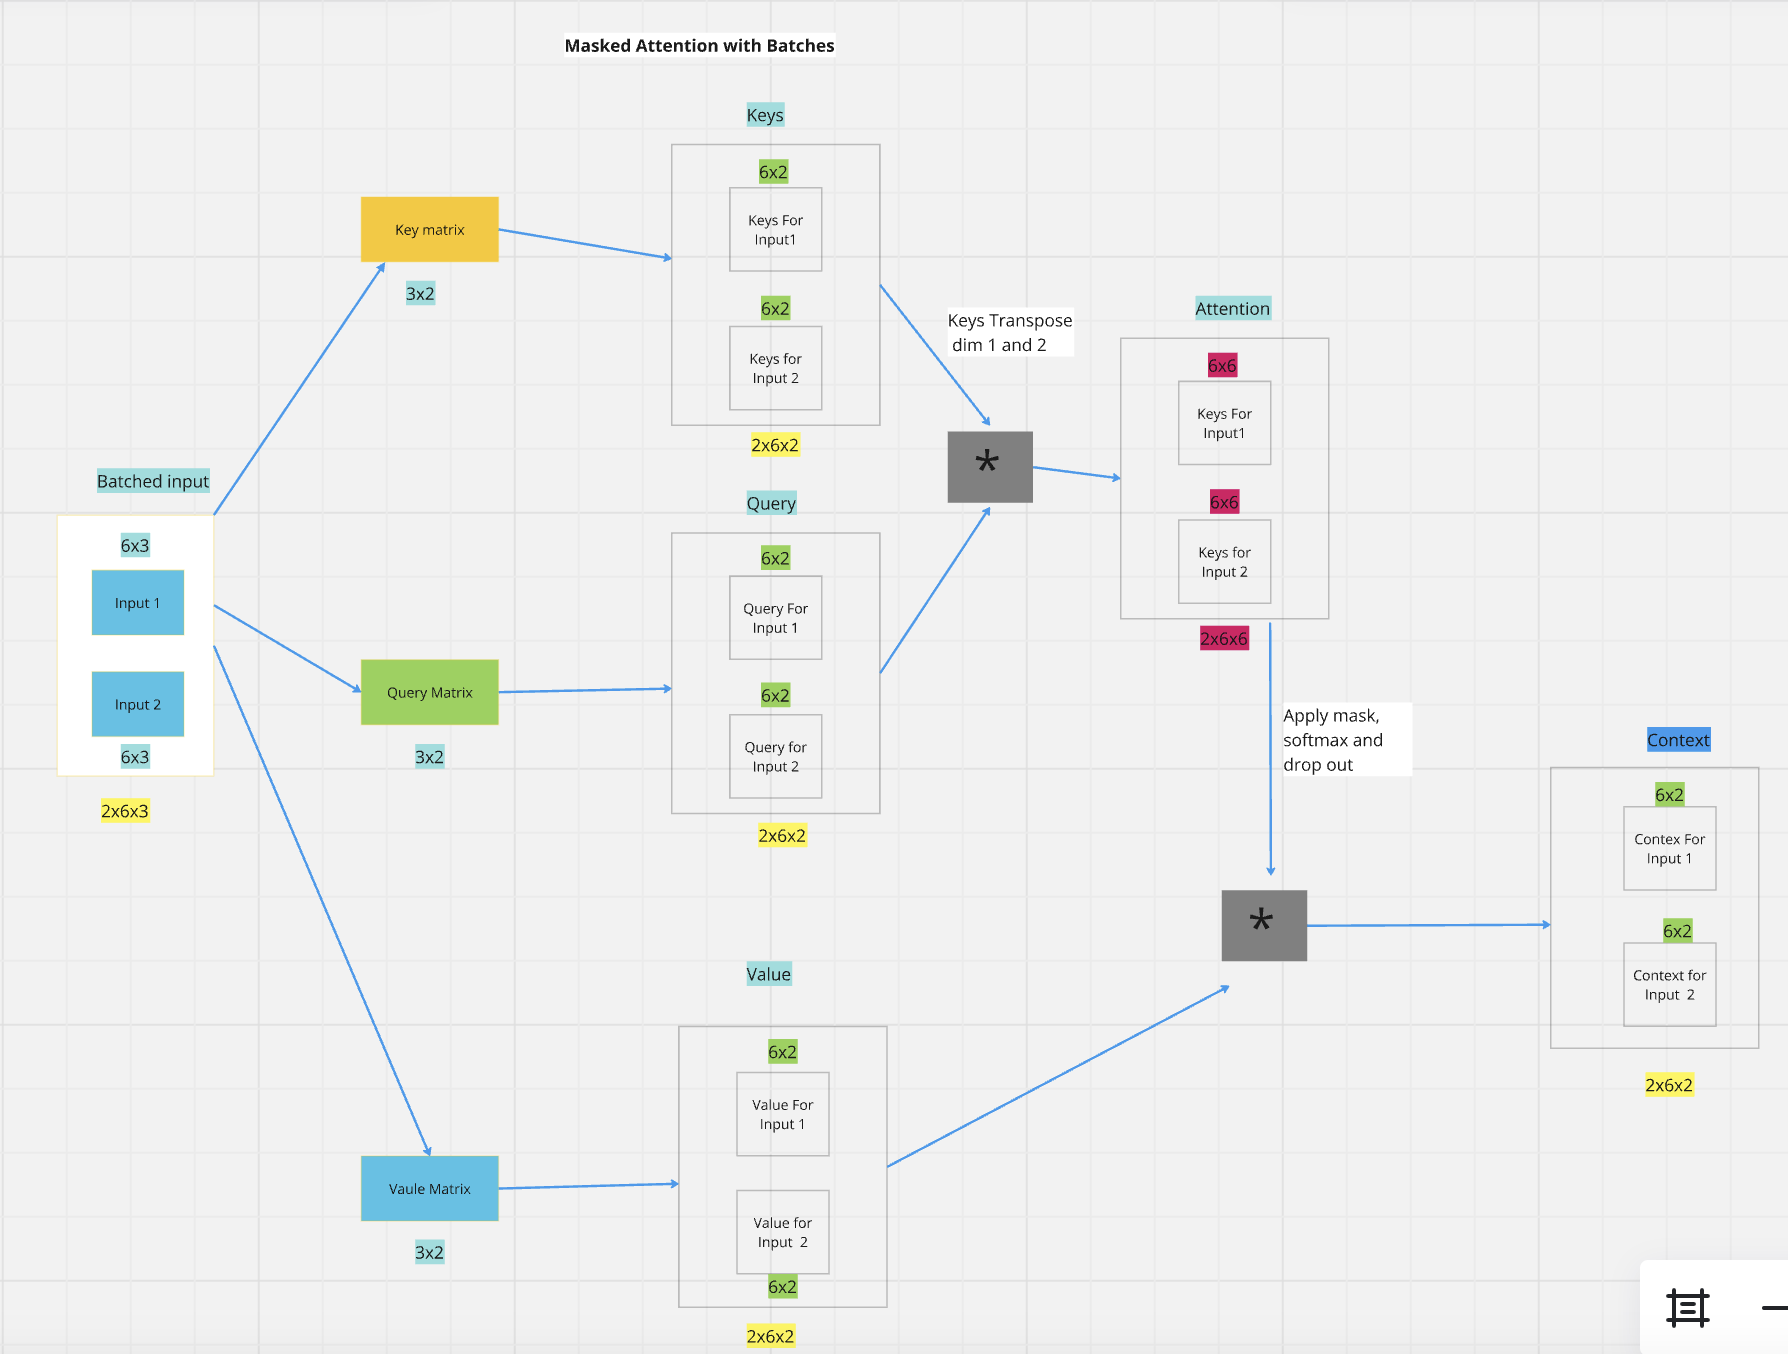

</div>

<div class="alert alert-block alert-warning">

The use of register_buffer in
PyTorch is not strictly necessary for all use cases but offers several advantages here. 

For
instance, when we use the CausalAttention class in our LLM, buffers are automatically
moved to the appropriate device (CPU or GPU) along with our model, which will be relevant
when training the LLM in future chapters. 

This means we don't need to manually ensure
these tensors are on the same device as your model parameters, avoiding device mismatch
errors.

</div>

<div class="alert alert-block alert-success">

We can use the CausalAttention class as follows, similar to SelfAttention previously:
    
</div>

In [29]:
print(d_in)

3


In [30]:
print(d_out)

2


In [31]:
torch.manual_seed(123)
context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)
context_vecs = ca(batch)
print("context_vecs.shape:", context_vecs.shape)

context_vecs.shape: torch.Size([2, 6, 2])


In [32]:
print(context_vecs)

tensor([[[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]],

        [[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]]], grad_fn=<UnsafeViewBackward0>)


<div class="alert alert-block alert-info">

As we can see, the resulting context vector is a 3D tensor where each token is now represented by a 2D
embedding:
    
</div>

<div class="alert alert-block alert-warning">

In the next section, we will expand on this concept
and implement a multi-head attention module, that implements several of such causal
attention mechanisms in parallel.

</div>